In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0805"
name_notebook = day + "-sq_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_angles(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

# X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
# X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 3,
    block_n_layers = 25,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

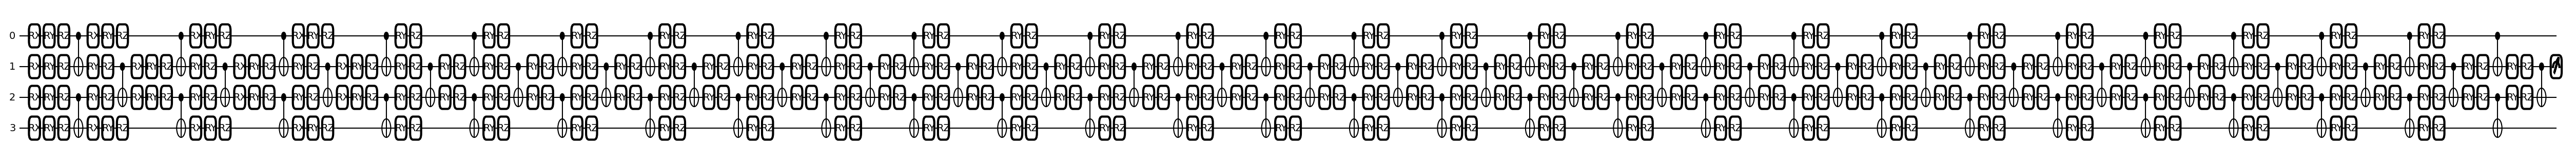

In [10]:
quantum_layer.draw(size=(50,3))

# Quantum model

In [11]:
layers = [quantum_layer()]

In [12]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
    # keep_track_params=True,
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [13]:
print(model(input_data[0]).item())
print(model(input_data[1]).item())

-0.4757863585415879
-0.15637274427879744


In [14]:
model.keep_track_params=True,

In [15]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.5},
    num_epochs = 25,                
    batch_size = 32,
)

Folder '../checkpoints/0805' created successfully.
Folder '../checkpoints/0805/models' created successfully.
Folder '../checkpoints/0805/plots' created successfully.
Folder '../checkpoints/0805/pdfs' created successfully.
Folder '../checkpoints/0805/notebooks' created successfully.
Folder '../checkpoints/0805/txts' created successfully.
Folder '../checkpoints/0805/versions' created successfully.
Epoch [0/2], Loss: 2.1640, Loss validation: 1.9381


KeyboardInterrupt: 

In [ ]:
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0804/txts/0804-sq_1qm_model_str_2.txt


Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_batches_2.png


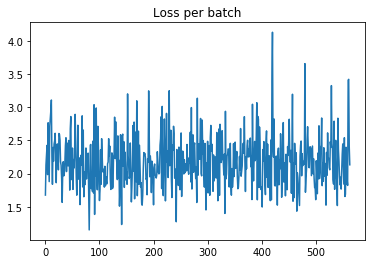

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_epoch_2.png


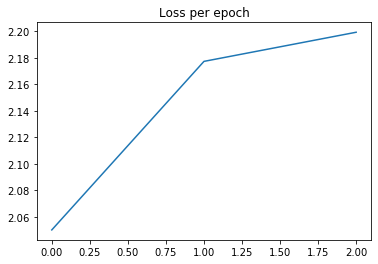

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_epoch_validation_2.png


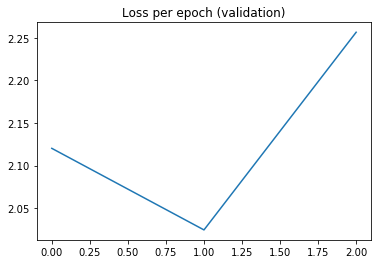

In [ ]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

In [ ]:
model.save_state_dict()

Model saved as peptide-QML/checkpoints/0804/models/0804-sq_1qm_2.pth


Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_0.embedding_weights_None_2.png


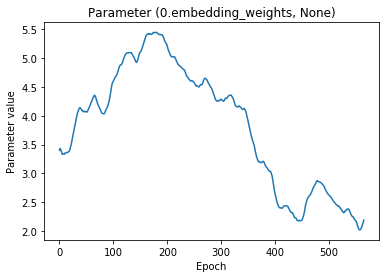

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_0.block_weights_None_2.png


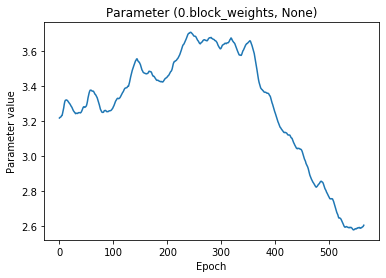

In [ ]:
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

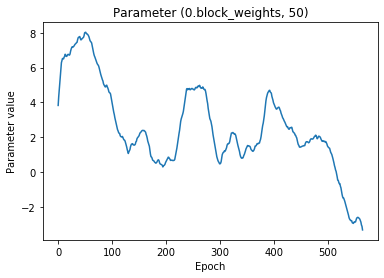

In [ ]:
model.plot_parameter(layer='0.block_weights', index=50)

In [ ]:
#load model
model.load_state_dict()

Model loaded from peptide-QML/checkpoints/0803/models/0803-sq_1qm_2.pth


In [ ]:
# print validation
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: 0.1391, 	 output: -0.0872, 	 loss: 1.6268
i: 1, 		 target: 0.0548, 	 output: 0.1519, 	 loss: 1.7703
i: 2, 		 target: -0.0419, 	 output: -0.5031, 	 loss: 10.9953
i: 3, 		 target: -0.0512, 	 output: -0.0659, 	 loss: 0.2862
i: 4, 		 target: 0.0182, 	 output: -0.3173, 	 loss: 18.4534
i: 5, 		 target: 0.2623, 	 output: 0.0216, 	 loss: 0.9178
i: 6, 		 target: -0.0885, 	 output: -0.2902, 	 loss: 2.2797
i: 7, 		 target: 0.1750, 	 output: -0.1070, 	 loss: 1.6113
i: 8, 		 target: 0.0811, 	 output: 0.2070, 	 loss: 1.5546
i: 9, 		 target: -0.0380, 	 output: 0.0210, 	 loss: 1.5537
i: 10, 		 target: 0.0295, 	 output: 0.1547, 	 loss: 4.2351
i: 11, 		 target: -0.0071, 	 output: -0.0893, 	 loss: 11.5054
i: 12, 		 target: -0.0317, 	 output: -0.2550, 	 loss: 7.0388
i: 13, 		 target: 0.1796, 	 output: -0.0040, 	 loss: 1.0225
i: 14, 		 target: -0.0739, 	 output: -0.3305, 	 loss: 3.4742
i: 15, 		 target: 0.2417, 	 output: -0.2142, 	 loss: 1.8864
i: 16, 		 target: 0.1376, 	 output: -0.1046, 

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main dc38ef2] data trained model
 1 file changed, 1002 insertions(+)
 create mode 100644 checkpoints/0803/txts/0803-sq_1qm_validation_2.txt
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 24 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 13.41 KiB | 2.23 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:raulconchello/peptide-QML.git
   4ca6e8e..dc38ef2  main -> main
